In [2]:
import pandas as pd
import ta 
import matplotlib.pyplot as plt

In [3]:
from dataclasses import dataclass

@dataclass
class Operation:
    time: str
    price: float
    stop_loss: float
    take_profit: float
    n_shares: int
    type: str

In [4]:
def get_portfolio_value(cash: float, long_ops: list[Operation], short_ops: list[Operation], current_price: float, n_shares: int) -> float:
    val = cash

    # add long positions value
    val += len(long_ops) * n_shares * current_price

    # TODO: add short positions value
    return val


In [5]:
data = pd.read_csv('Binance_BTCUSDT_1h.csv').dropna()
data

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_10260\3546308744.py:1: DtypeWarning: Columns (0,3,4,5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Binance_BTCUSDT_1h.csv').dropna()


,,,,,,,,,https://www.CryptoDataDownload.com
Unix,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount
1758582000000,2025-09-22 23:00:00,BTCUSDT,112643.25,112739.14,112592.2,112650.99,135.31095,15244940.8306451,34083
1758578400000,2025-09-22 22:00:00,BTCUSDT,112969.99,112970.0,112594.33,112643.25,289.60715,32646911.0027458,42836
1758574800000,2025-09-22 21:00:00,BTCUSDT,112781.87,112970.0,112602.79,112969.99,293.31156,33074925.4786085,42931
1758571200000,2025-09-22 20:00:00,BTCUSDT,112122.9,112977.41,111975.28,112781.88,596.84005,67075083.9870225,93553
...,...,...,...,...,...,...,...,...,...
1502956800000,2017-08-17 08:00:00,BTCUSDT,4333.32,4377.85,4333.32,4360.69,0.972807,4239.503586,28
1502953200000,2017-08-17 07:00:00,BTCUSDT,4316.62,4349.99,4287.41,4349.99,4.443249,19241.0583,25
1502949600000,2017-08-17 06:00:00,BTCUSDT,4330.29,4345.45,4309.37,4324.35,7.229691,31282.31267,36
1502946000000,2017-08-17 05:00:00,BTCUSDT,4308.83,4328.69,4291.37,4315.32,23.234916,100304.823567,102


In [ ]:
rsi_indicator = ta.momentum.RSIIndicator(data.Close, window=17)
data['RSI'] = rsi_indicator.rsi()

# MACD
macd_indicator = ta.trend.MACD(
    data.Close,
    window_slow=43,
    window_fast=7,
    window_sign=9  
)
data['MACD'] = macd_indicator.macd()
data['MACD_signal'] = macd_indicator.macd_signal()

# Bollinger Bands
bb_indicator = ta.volatility.BollingerBands(
    data.Close,
    window=29,
    window_dev=2
)
data['BB_high'] = bb_indicator.bollinger_hband()
data['BB_low'] = bb_indicator.bollinger_lband()

# --- Limpiar datos faltantes ---
historic = data.dropna().copy()

# --- Señales de compra y venta ---
historic['RSI_buy'] = historic['RSI'] < 20
historic['RSI_sell'] = historic['RSI'] > 80

historic['MACD_buy'] = historic['MACD'] > historic['MACD_signal']
historic['MACD_sell'] = historic['MACD'] < historic['MACD_signal']

historic['BB_buy'] = historic['Close'] < historic['BB_low']
historic['BB_sell'] = historic['Close'] > historic['BB_high']


In [54]:
COM = 0.125 / 100
SL = 0.12133037352763151
TP = 0.11737328781042725

cash = 1_000_000
n_shares = 363

active_long_positions: list[Operation] = []
portfolio_value = [cash]


trades = []

for i, row in historic.iterrows():

    
    for position in active_long_positions.copy():
        if row.Close > position.take_profit or row.Close < position.stop_loss:
            exit_price = row.Close * (1 - COM)
            pnl = (exit_price - position.price) * position.n_shares
            trades.append({
                'Datetime': row.Datetime,
                'Type': position.type,
                'Entry_price': position.price,
                'Exit_price': exit_price,
                'Stop_loss': position.stop_loss,
                'Take_profit': position.take_profit,
                'Shares': position.n_shares,
                'PnL': pnl
            })
            cash += exit_price * position.n_shares
            active_long_positions.remove(position)

    
    signals = [row.RSI_buy, row.MACD_buy, row.BB_buy]
    buy_signal = sum(signals) >= 2

    if not buy_signal:
        portfolio_value.append(get_portfolio_value(cash, active_long_positions, [], row.Close, n_shares))
        continue

    # --- Verificar efectivo ---
    if cash < row.Close * n_shares * (1 + COM):
        portfolio_value.append(get_portfolio_value(cash, active_long_positions, [], row.Close, n_shares))
        continue

    # --- Abrir posición long ---
    cash -= row.Close * n_shares * (1 + COM)
    active_long_positions.append(
        Operation(
            time=row.Datetime,
            price=row.Close,
            stop_loss=row.Close * (1 - SL),
            take_profit=row.Close * (1 + TP),
            n_shares=n_shares,
            type='LONG'
        )
    )

    portfolio_value.append(get_portfolio_value(cash, active_long_positions, [], row.Close, n_shares))

# --- Cerrar todas al final ---
for position in active_long_positions:
    exit_price = row.Close * (1 - COM)
    pnl = (exit_price - position.price) * position.n_shares
    trades.append({
        'Datetime': row.Datetime,
        'Type': position.type,
        'Entry_price': position.price,
        'Exit_price': exit_price,
        'Stop_loss': position.stop_loss,
        'Take_profit': position.take_profit,
        'Shares': position.n_shares,
        'PnL': pnl
    })
    cash += exit_price * position.n_shares

active_long_positions = []

# Crear DataFrame con todos los trades
trades_df = pd.DataFrame(trades)
print(trades_df.head())

              Datetime  Type  Entry_price  Exit_price   Stop_loss  \
0  2021-01-25 14:30:00  LONG   127.080001  144.379297  111.661337   
1  2021-01-25 14:30:00  LONG   127.225196  144.379297  111.788915   
2  2021-03-05 16:10:00  LONG   134.910003  118.122265  118.541322   
3  2021-03-05 16:10:00  LONG   134.779907  118.122265  118.427011   
4  2021-03-05 16:10:00  LONG   134.619995  118.122265  118.286501   

   Take_profit  Shares          PnL  
0   141.995799     363  6279.644449  
1   142.158036     363  6226.938664  
2   150.744834     363 -6093.948759  
3   150.599468     363 -6046.723911  
4   150.420786     363 -5988.675855  


In [55]:
cash


1258473.1074467571

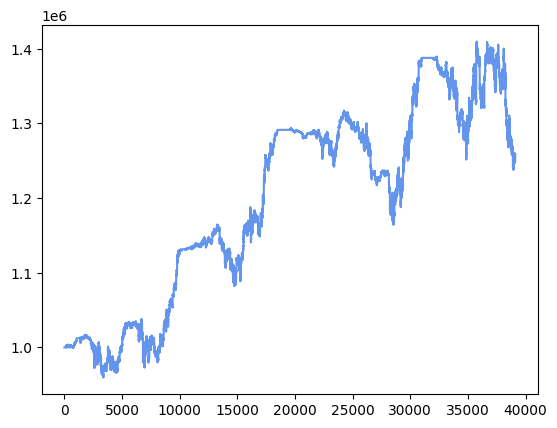

In [56]:
plt.plot(portfolio_value, color='cornflowerblue')


In [48]:
import optuna

def backtest_full(data, trail) -> float:
    data = data.copy()

    # --- Parámetros a optimizar ---
    rsi_window = trail.suggest_int('rsi_window', 5, 50)
    macd_fast = trail.suggest_int('macd_fast', 5, 20)
    macd_slow = trail.suggest_int('macd_slow', 20, 50)
    bb_window = trail.suggest_int('bb_window', 10, 30)
    stop_loss = trail.suggest_float('stop_loss', 0.01, 0.15)
    take_profit = trail.suggest_float('take_profit', 0.01, 0.15)
    n_shares = trail.suggest_int('n_shares', 50, 500)

    # --- Indicadores ---
    rsi_indicator = ta.momentum.RSIIndicator(data.Close, window=rsi_window)
    data['RSI'] = rsi_indicator.rsi()

    macd_indicator = ta.trend.MACD(data.Close, window_slow=macd_slow, window_fast=macd_fast)
    data['MACD'] = macd_indicator.macd()
    data['MACD_signal'] = macd_indicator.macd_signal()

    bb_indicator = ta.volatility.BollingerBands(data.Close, window=bb_window, window_dev=2)
    data['BB_high'] = bb_indicator.bollinger_hband()
    data['BB_low'] = bb_indicator.bollinger_lband()

    historic = data.dropna().copy()

    # --- Señales ---
    historic['RSI_buy'] = historic['RSI'] < 20
    historic['RSI_sell'] = historic['RSI'] > 80
    historic['MACD_buy'] = historic['MACD'] > historic['MACD_signal']
    historic['MACD_sell'] = historic['MACD'] < historic['MACD_signal']
    historic['BB_buy'] = historic['Close'] < historic['BB_low']
    historic['BB_sell'] = historic['Close'] > historic['BB_high']

    # --- Configuración trading ---
    COM = 0.125 / 100
    SL = stop_loss
    TP = take_profit

    cash = 1_000_000
    active_long_positions: list[Operation] = []

    for i, row in historic.iterrows():
        # --- Cerrar posiciones ---
        for position in active_long_positions.copy():
            if row.Close > position.take_profit or row.Close < position.stop_loss:
                cash += row.Close * position.n_shares * (1 - COM)
                active_long_positions.remove(position)

        # --- Señal de compra ---
        signals = [row.RSI_buy, row.MACD_buy, row.BB_buy]
        buy_signal = sum(signals) >= 2

        if not buy_signal:
            continue

        # --- Verificar cash ---
        if cash < row.Close * n_shares * (1 + COM):
            continue

        # --- Abrir posición long ---
        cash -= row.Close * n_shares * (1 + COM)
        active_long_positions.append(
            Operation(
                time=row.Datetime,
                price=row.Close,
                stop_loss=row.Close * (1 - SL),
                take_profit=row.Close * (1 + TP),
                n_shares=n_shares,
                type='LONG'
            )
        )

    # --- Cerrar todas al final ---
    cash += row.Close * len(active_long_positions) * n_shares * (1 - COM)
    active_long_positions = []

    # --- Retornar retorno relativo ---
    return (cash / 1_000_000) - 1

# --- Optimización ---
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: backtest_full(data, trial), n_trials=20)


[I 2025-09-29 20:17:42,451] A new study created in memory with name: no-name-a1519e29-a10e-4792-ba33-d8ddc363a80b
[I 2025-09-29 20:17:49,732] Trial 0 finished with value: -0.01779861330456689 and parameters: {'rsi_window': 35, 'macd_fast': 10, 'macd_slow': 50, 'bb_window': 21, 'stop_loss': 0.04698017976339842, 'take_profit': 0.13711362005213257, 'n_shares': 138}. Best is trial 0 with value: -0.01779861330456689.
[I 2025-09-29 20:17:58,494] Trial 1 finished with value: 0.05344446714090956 and parameters: {'rsi_window': 21, 'macd_fast': 9, 'macd_slow': 44, 'bb_window': 16, 'stop_loss': 0.04461159018508133, 'take_profit': 0.052182272052510054, 'n_shares': 378}. Best is trial 1 with value: 0.05344446714090956.
[I 2025-09-29 20:18:04,297] Trial 2 finished with value: 0.0012025191863751505 and parameters: {'rsi_window': 50, 'macd_fast': 5, 'macd_slow': 27, 'bb_window': 28, 'stop_loss': 0.010883137914069774, 'take_profit': 0.04611889775609759, 'n_shares': 295}. Best is trial 1 with value: 0.0

In [49]:
study.best_params


{'rsi_window': 17,
 'macd_fast': 7,
 'macd_slow': 43,
 'bb_window': 29,
 'stop_loss': 0.12133037352763151,
 'take_profit': 0.11737328781042725,
 'n_shares': 363}